## _*VQE; using its callback to monitor optimization progress*_

This notebook demonstrates using Qiskit Aqua's VQE algorithm to plot graphs of the convergence path to ground state energy with different optimizers.

This notebook uses the callback capability of VQE to capture information at each objective functional evaluation where it is computing the energy using the parameterized variational form. While the params themselves are also part of the callback we are only interested in the energy value here to plot the convergence. 

Note: other variational algorithms such as QAOA and QSVM have similar callbacks.

In [1]:
import numpy as np
import pylab

from qiskit import BasicAer
from qiskit.aqua import Operator, QuantumInstance, aqua_globals
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.aqua.components.variational_forms import RY

First we create a qubit operator for VQE. Here we have taken a set of paulis that were originally computed by qiskit-chemistry for an H2 molecule.

In [2]:
pauli_dict = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.052373245772859}, "label": "II"},
              {"coeff": {"imag": 0.0, "real": 0.39793742484318045}, "label": "ZI"},
              {"coeff": {"imag": 0.0, "real": -0.39793742484318045}, "label": "IZ"},
              {"coeff": {"imag": 0.0, "real": -0.01128010425623538}, "label": "ZZ"},
              {"coeff": {"imag": 0.0, "real": 0.18093119978423156}, "label": "XX"}
              ]
}

qubit_op = Operator.load_from_dict(pauli_dict)

Now we loop over the set of optimizers. The defaults for maxiters/evals for the respective optimizers is more than sufficient to converge the above H2 problem so we do not need to add any logic to set accordingly.

In [3]:
optimizers = [COBYLA, L_BFGS_B, SLSQP]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
num_qubits = qubit_op.num_qubits

for i in range(len(optimizers)):
    aqua_globals.random_seed = 250
    optimizer = optimizers[i]()
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    init_state = Zero(num_qubits)
    var_form = RY(num_qubits, initial_state=init_state)

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
  
    algo = VQE(qubit_op, var_form, optimizer, 'matrix', callback=store_intermediate_result)
    backend = BasicAer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend=backend)  
    algo_result = algo.run(quantum_instance)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print('\rOptimization complete      ');

Optimization complete      


Now from the callback data we stored we can plot the energy value at each objective function call each optimzer makes. An optimizer using a finite difference method for computing gradient has that characteristic step like plot where for a number of evaluations it is computing the value for close by points to establish a gradient (the close by points having very similiar values whose difference cannot be seen on the scale of the graph here).

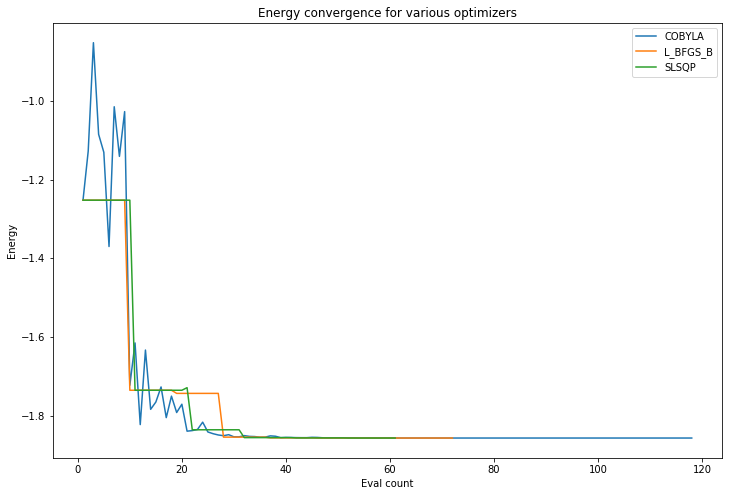

In [4]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], converge_vals[i], label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

Finally since the above problem is still easily tractable classically we can use ExactEigensolver to compute a reference value for the solution. We can now plot the difference from the resultant exact solution as the energy converges with VQE towards the minimum value which should be that exact classical solution.

In [5]:
ee = ExactEigensolver(qubit_op)
result = ee.run()
ref = result['energy']
print('Reference value: {}'.format(ref))

Reference value: -1.85727503020238


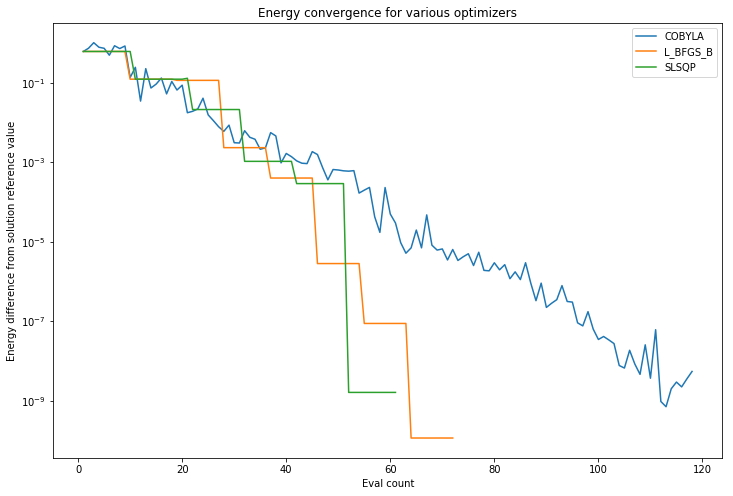

In [6]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=optimizers[i].__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right')